### Question 3: Dimensionality Reduction for Image Compression

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [12]:
def show_patches(patches,patch_size,N=100):
    """Displays the first N pataches in a patch vector array
    as a grid of patch images. Requires that the patch vector
    represented by patches[n,:] can be re-shaped using
    patches[n,:].reshape(patch_size,patch_size,3).

    Parameters
    ----------
    patches : array of shape(M, patch_size*patch_size*3)
    patch_size : size of the patch
    N : int, optional
        number of patches to display, by default 100
    """
    N   = min(patches.shape[0],N)
    s   = np.ceil(np.sqrt(N)).astype(int)
    for n in range(N):
        plt.subplot(s,s,n+1)
        plt.imshow(patches[n,:].reshape(patch_size,patch_size,3))
        plt.axis("off")
    plt.tight_layout()

### Question 3 (a)

Original image shape: (1080, 1920, 3)
Cropped image shape: (1080, 1920, 3)


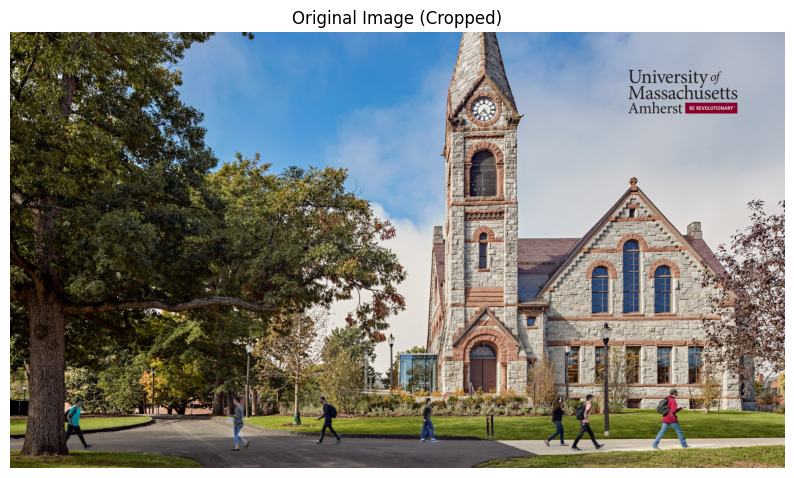

Patch array P shape: (32400, 8, 8, 3)
Patch vector array V shape: (32400, 192)


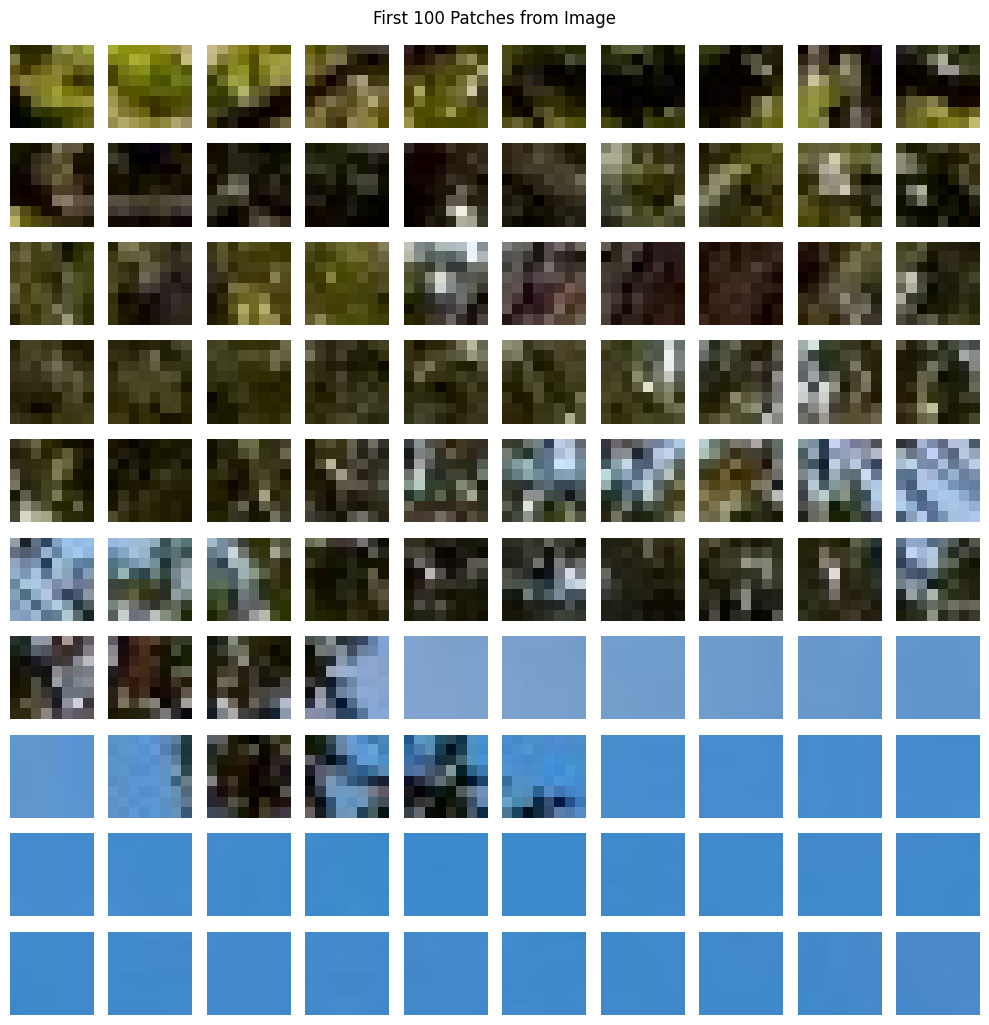

In [13]:
patch_size = 8
image_path = "umass.jpg"
img = np.array(Image.open(image_path)) / 255

H, W, C = img.shape
H_cropped = (H // patch_size) * patch_size
W_cropped = (W // patch_size) * patch_size
img_cropped = img[:H_cropped, :W_cropped, :]

print(f"Original image shape: {img.shape}")
print(f"Cropped image shape: {img_cropped.shape}")

plt.figure(figsize=(10, 8))
plt.imshow(img_cropped)
plt.title("Original Image (Cropped)")
plt.axis("off")
plt.show()

num_patches_h = H_cropped // patch_size
num_patches_w = W_cropped // patch_size
num_patches = num_patches_h * num_patches_w

P = np.zeros((num_patches, patch_size, patch_size, 3))
patch_idx = 0
for i in range(num_patches_h):
    for j in range(num_patches_w):
        P[patch_idx] = img_cropped[i*patch_size:(i+1)*patch_size,
                                    j*patch_size:(j+1)*patch_size, :]
        patch_idx += 1

print(f"Patch array P shape: {P.shape}")

V = P.reshape(num_patches, patch_size * patch_size * 3)
print(f"Patch vector array V shape: {V.shape}")

plt.figure(figsize=(10, 10))
show_patches(V, patch_size, N=100)
plt.suptitle("First 100 Patches from Image", y=1.02)
plt.show()

### Question 3(b)

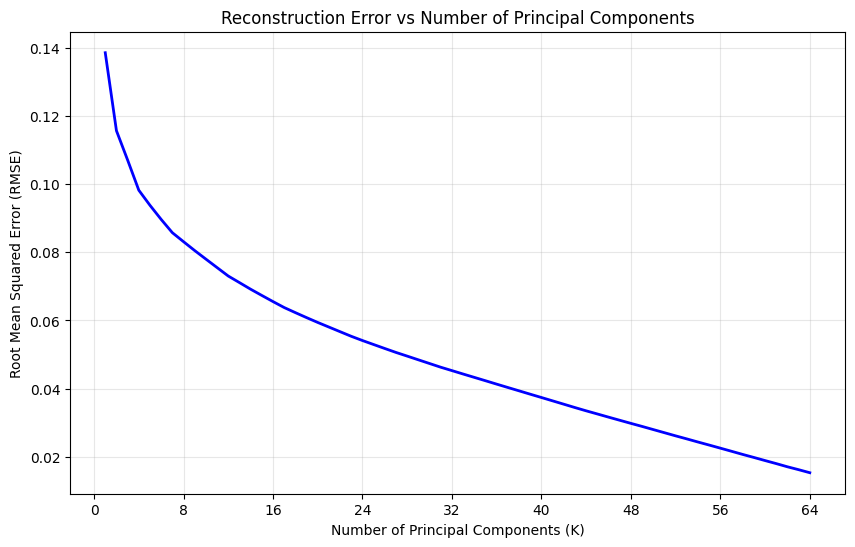

In [14]:
K_values = range(1, 65)
reconstruction_errors = []

for K in K_values:
    pca = PCA(n_components=K)
    pca.fit(V)

    Z = pca.transform(V)

    R = pca.inverse_transform(Z)

    rmse = np.sqrt(np.mean((V - R) ** 2))
    reconstruction_errors.append(rmse)

plt.figure(figsize=(10, 6))
plt.plot(K_values, reconstruction_errors, 'b-', linewidth=2)
plt.xlabel('Number of Principal Components (K)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Reconstruction Error vs Number of Principal Components')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 65, 8))
plt.show()

### Question 3(c)

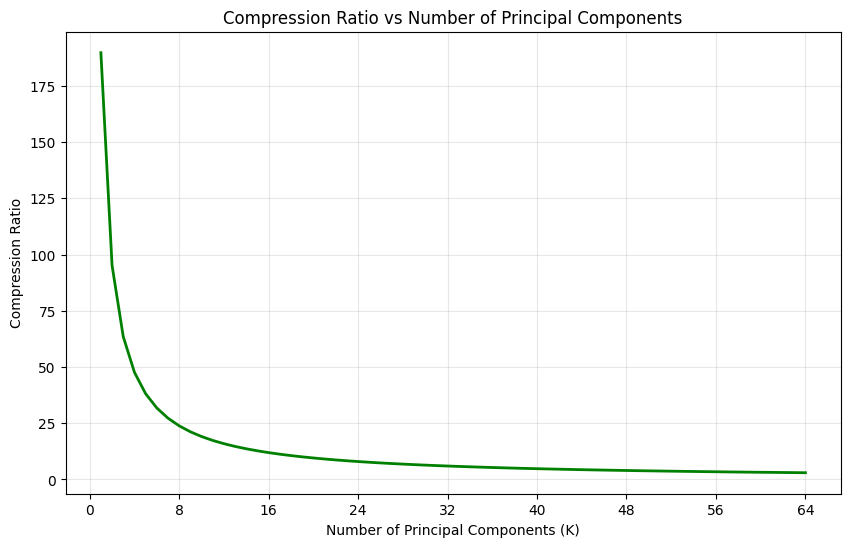

In [15]:
compression_ratios = []
original_elements = H_cropped * W_cropped * 3

for K in K_values:
    elements_in_Z = num_patches * K
    pca_parameters = K * (patch_size * patch_size * 3) + (patch_size * patch_size * 3)

    s = elements_in_Z + pca_parameters

    compression_ratio = original_elements / s
    compression_ratios.append(compression_ratio)

plt.figure(figsize=(10, 6))
plt.plot(K_values, compression_ratios, 'g-', linewidth=2)
plt.xlabel('Number of Principal Components (K)')
plt.ylabel('Compression Ratio')
plt.title('Compression Ratio vs Number of Principal Components')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 65, 8))
plt.show()

### Question 3(d)

Reconstructed image shape: (1080, 1920, 3)
Max difference from original: 0.0


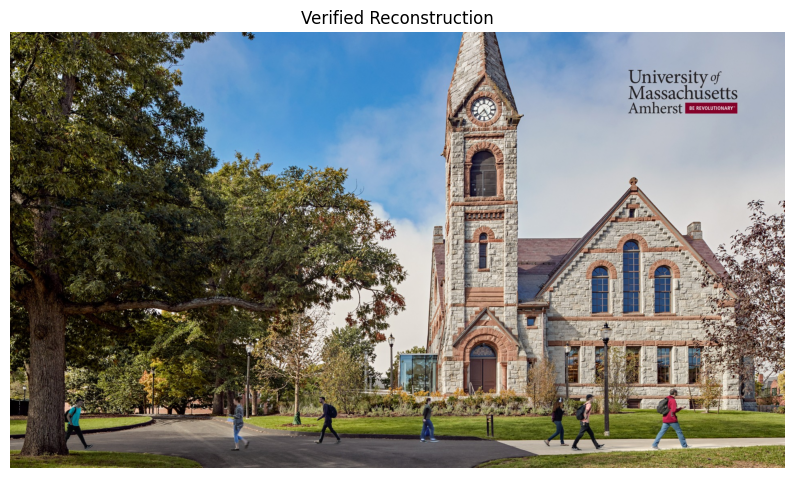

In [16]:
def patch_vectors_to_image(V, H, W, patch_size=8):

    num_patches_h = H // patch_size
    num_patches_w = W // patch_size

    P = V.reshape(-1, patch_size, patch_size, 3)

    img = np.zeros((H, W, 3))
    patch_idx = 0
    for i in range(num_patches_h):
        for j in range(num_patches_w):
            img[i*patch_size:(i+1)*patch_size,
                j*patch_size:(j+1)*patch_size, :] = P[patch_idx]
            patch_idx += 1

    return img

reconstructed_img = patch_vectors_to_image(V, H_cropped, W_cropped, patch_size)
print(f"Reconstructed image shape: {reconstructed_img.shape}")
print(f"Max difference from original: {np.max(np.abs(reconstructed_img - img_cropped))}")

# Display to verify
plt.figure(figsize=(10, 8))
plt.imshow(reconstructed_img)
plt.title("Verified Reconstruction")
plt.axis("off")
plt.show()

### Question 3(e)

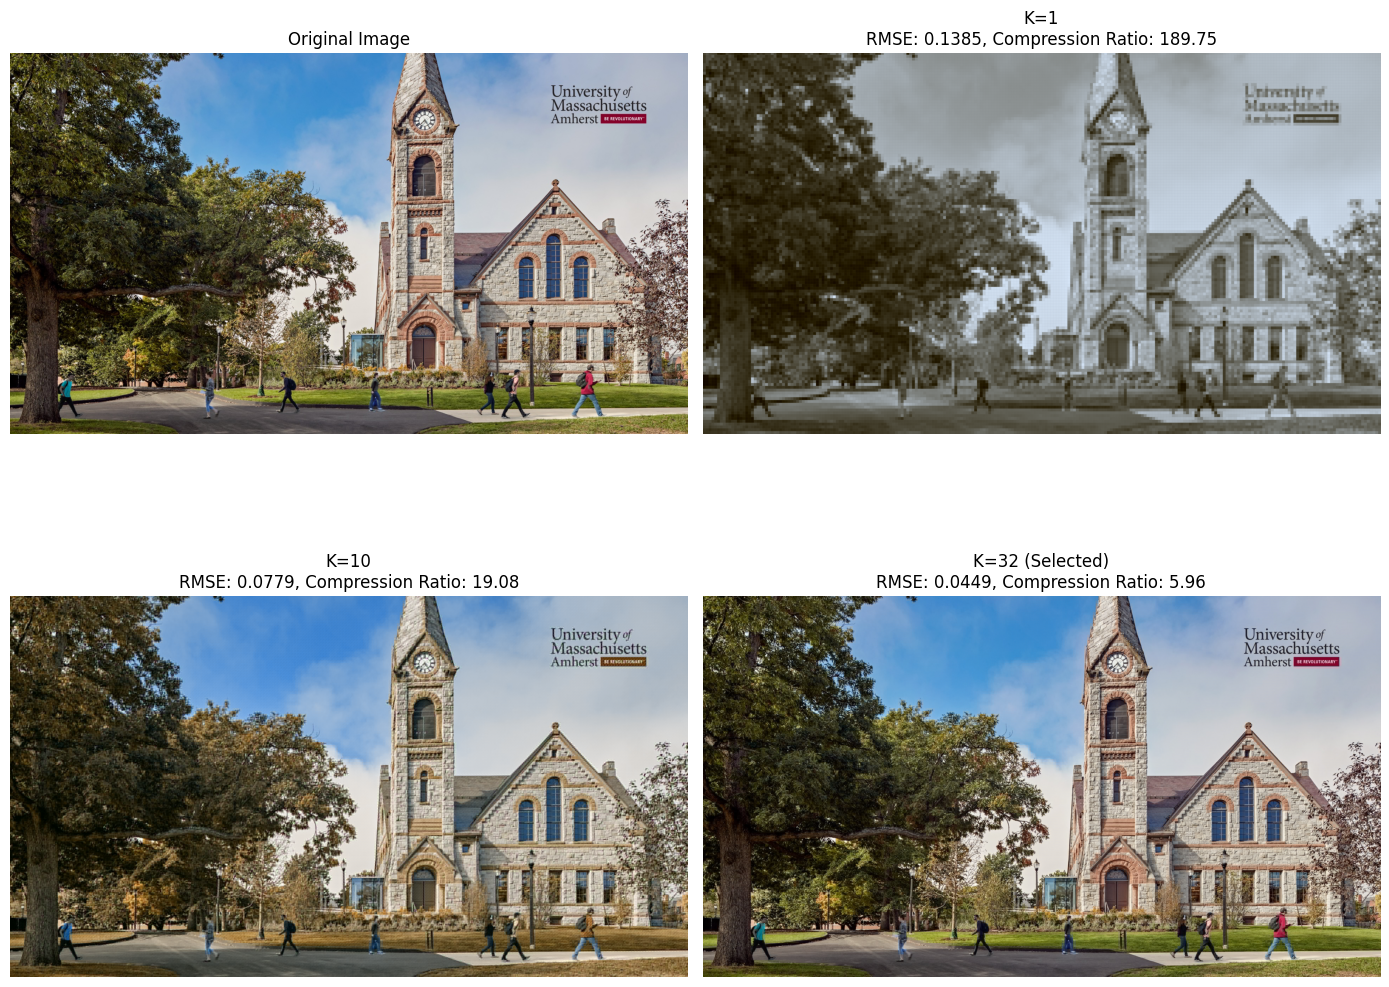

Summary of Results
K=1:  RMSE = 0.1385, Compression Ratio = 189.75
K=10: RMSE = 0.0779, Compression Ratio = 19.08
K=32 (Selected): RMSE = 0.0449, Compression Ratio = 5.96


In [17]:
def reconstruct_image_with_pca(V, K, H, W, patch_size=8):

    pca = PCA(n_components=K)
    pca.fit(V)

    Z = pca.transform(V)
    R = pca.inverse_transform(Z)

    R = np.clip(R, 0, 1)

    img_reconstructed = patch_vectors_to_image(R, H, W, patch_size)

    rmse = np.sqrt(np.mean((V - R) ** 2))

    num_patches = V.shape[0]
    original_elements = H * W * 3
    elements_in_Z = num_patches * K
    pca_parameters = K * (patch_size * patch_size * 3) + (patch_size * patch_size * 3)
    s = elements_in_Z + pca_parameters
    compression_ratio = original_elements / s

    return img_reconstructed, rmse, compression_ratio

img_k1, rmse_k1, cr_k1 = reconstruct_image_with_pca(V, 1, H_cropped, W_cropped, patch_size)

img_k10, rmse_k10, cr_k10 = reconstruct_image_with_pca(V, 10, H_cropped, W_cropped, patch_size)

selected_K = 32
img_selected, rmse_selected, cr_selected = reconstruct_image_with_pca(V, selected_K, H_cropped, W_cropped, patch_size)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

axes[0, 0].imshow(img_cropped)
axes[0, 0].set_title("Original Image")
axes[0, 0].axis("off")
axes[0, 1].imshow(img_k1)
axes[0, 1].set_title(f"K=1\nRMSE: {rmse_k1:.4f}, Compression Ratio: {cr_k1:.2f}")
axes[0, 1].axis("off")

axes[1, 0].imshow(img_k10)
axes[1, 0].set_title(f"K=10\nRMSE: {rmse_k10:.4f}, Compression Ratio: {cr_k10:.2f}")
axes[1, 0].axis("off")

axes[1, 1].imshow(img_selected)
axes[1, 1].set_title(f"K={selected_K} (Selected)\nRMSE: {rmse_selected:.4f}, Compression Ratio: {cr_selected:.2f}")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

print("=" * 60)
print("Summary of Results")
print("=" * 60)
print(f"K=1:  RMSE = {rmse_k1:.4f}, Compression Ratio = {cr_k1:.2f}")
print(f"K=10: RMSE = {rmse_k10:.4f}, Compression Ratio = {cr_k10:.2f}")
print(f"K={selected_K} (Selected): RMSE = {rmse_selected:.4f}, Compression Ratio = {cr_selected:.2f}")
print("=" * 60)